
# Tarea N°02

## Instrucciones

1.- Completa tus datos personales (nombre y rol USM) en siguiente celda.


* __Nombre__: Maryon Morales Lorca

* __Rol__: 201710510-0

2.- Debes _pushear_ este archivo con tus cambios a tu repositorio personal del curso, incluyendo datos, imágenes, scripts, etc.

3.- Se evaluará:
    - Soluciones
    - Código
    - Que Binder esté bien configurado.
    - Al presionar  `Kernel -> Restart Kernel and Run All Cells` deben ejecutarse todas las celdas sin error.

## I.- Clasificación de dígitos


En este laboratorio realizaremos el trabajo de reconocer un dígito a partir de una imagen.


![rgb](https://www.wolfram.com/language/11/neural-networks/assets.en/digit-classification/smallthumb_1.png)

El objetivo es a partir de los datos, hacer la mejor predicción de cada imagen. Para ellos es necesario realizar los pasos clásicos de un proyecto de _Machine Learning_, como estadística descriptiva, visualización y preprocesamiento. 

* Se solicita ajustar al menos tres modelos de clasificación:
 * Regresión logística
 * K-Nearest Neighbours 
 * Uno o más algoritmos a su elección [link](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) (es obligación escoger un _estimator_ que tenga por lo menos un hiperparámetro). 
 
 
* En los modelos que posean hiperparámetros es mandatorio buscar el/los mejores con alguna técnica disponible en `scikit-learn` ([ver más](https://scikit-learn.org/stable/modules/grid_search.html#tuning-the-hyper-parameters-of-an-estimator)).
* Para cada modelo, se debe realizar _Cross Validation_ con 10 _folds_ utilizando los datos de entrenamiento con tal de determinar un intervalo de confianza para el _score_ del modelo.
* Realizar una predicción con cada uno de los tres modelos con los datos _test_ y obtener el _score_. 
* Analizar sus métricas de error (**accuracy**, **precision**, **recall**, **f-score**)



### Exploración de los datos
A continuación se carga el conjunto de datos a utilizar, a través del sub-módulo `datasets` de `sklearn`.

In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score,f1_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from metrics_classification import *

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

from sklearn.datasets import make_classification
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV

from time import time

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve

from sklearn.metrics import roc_curve, auc
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from itertools import cycle

from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

%matplotlib inline

In [2]:
digits_dict = datasets.load_digits()
print(digits_dict["DESCR"])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [3]:
digits_dict.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [4]:
digits_dict["target"]

array([0, 1, 2, ..., 8, 9, 8])

A continuación se crea dataframe declarado como `digits` con los datos de `digits_dict` tal que tenga 65 columnas, las 6 primeras a la representación de la imagen en escala de grises (0-blanco, 255-negro) y la última correspondiente al dígito (`target`) con el nombre _target_.

In [5]:
digits = (
    pd.DataFrame(
        digits_dict["data"],
    )
    .rename(columns=lambda x: f"c{x:02d}")
    .assign(target=digits_dict["target"])
    .astype(int)
)

digits.head(25)

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,target
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4
5,0,0,12,10,0,0,0,0,0,0,...,0,0,0,9,16,16,10,0,0,5
6,0,0,0,12,13,0,0,0,0,0,...,0,0,0,1,9,15,11,3,0,6
7,0,0,7,8,13,16,15,1,0,0,...,0,0,0,13,5,0,0,0,0,7
8,0,0,9,14,8,1,0,0,0,0,...,0,0,0,11,16,15,11,1,0,8
9,0,0,11,12,0,0,0,0,0,2,...,0,0,0,9,12,13,3,0,0,9


### Ejercicio 1
**Análisis exploratorio:** Realiza tu análisis exploratorio, no debes olvidar nada! Recuerda, cada análisis debe responder una pregunta.

Algunas sugerencias:

* ¿Cómo se distribuyen los datos?
* ¿Cuánta memoria estoy utilizando?
* ¿Qué tipo de datos son?
* ¿Cuántos registros por clase hay?
* ¿Hay registros que no se correspondan con tu conocimiento previo de los datos?





**¿Cómo se distribuyen los datos?**

**¿Cuánta memoria estoy utilizando?
¿Qué tipo de datos son?**

In [6]:
digits.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1797 entries, 0 to 1796
Data columns (total 65 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   c00     1797 non-null   int32
 1   c01     1797 non-null   int32
 2   c02     1797 non-null   int32
 3   c03     1797 non-null   int32
 4   c04     1797 non-null   int32
 5   c05     1797 non-null   int32
 6   c06     1797 non-null   int32
 7   c07     1797 non-null   int32
 8   c08     1797 non-null   int32
 9   c09     1797 non-null   int32
 10  c10     1797 non-null   int32
 11  c11     1797 non-null   int32
 12  c12     1797 non-null   int32
 13  c13     1797 non-null   int32
 14  c14     1797 non-null   int32
 15  c15     1797 non-null   int32
 16  c16     1797 non-null   int32
 17  c17     1797 non-null   int32
 18  c18     1797 non-null   int32
 19  c19     1797 non-null   int32
 20  c20     1797 non-null   int32
 21  c21     1797 non-null   int32
 22  c22     1797 non-null   int32
 23  c23     1797 

**¿Cuántos registros por clase hay?**

In [7]:
for i in digits['target'].unique():
    count = len(digits[digits['target']==i]['target'])
    print("Hay",count,"registros de la clase",i)

Hay 178 registros de la clase 0
Hay 182 registros de la clase 1
Hay 177 registros de la clase 2
Hay 183 registros de la clase 3
Hay 181 registros de la clase 4
Hay 182 registros de la clase 5
Hay 181 registros de la clase 6
Hay 179 registros de la clase 7
Hay 174 registros de la clase 8
Hay 180 registros de la clase 9


**¿Hay registros que no se correspondan con tu conocimiento previo de los datos?**

Sí, ya que solo conocía int64 e int, aunque investigando noté que int e int32 es lo mismo.



### Ejercicio 2
**Visualización:** Para visualizar los datos utilizaremos el método `imshow` de `matplotlib`. Resulta necesario convertir el arreglo desde las dimensiones (1,64)  a (8,8) para que la imagen sea cuadrada y pueda distinguirse el dígito. Superpondremos además el label correspondiente al dígito, mediante el método `text`. Esto nos permitirá comparar la imagen generada con la etiqueta asociada a los valores. Realizaremos lo anterior para los primeros 25 datos del archivo.

In [8]:
digits_dict["images"][0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

Visualiza imágenes de los dígitos utilizando la llave `images` de `digits_dict`. 

Sugerencia: Utiliza `plt.subplots` y el método `imshow`. Puedes hacer una grilla de varias imágenes al mismo tiempo!

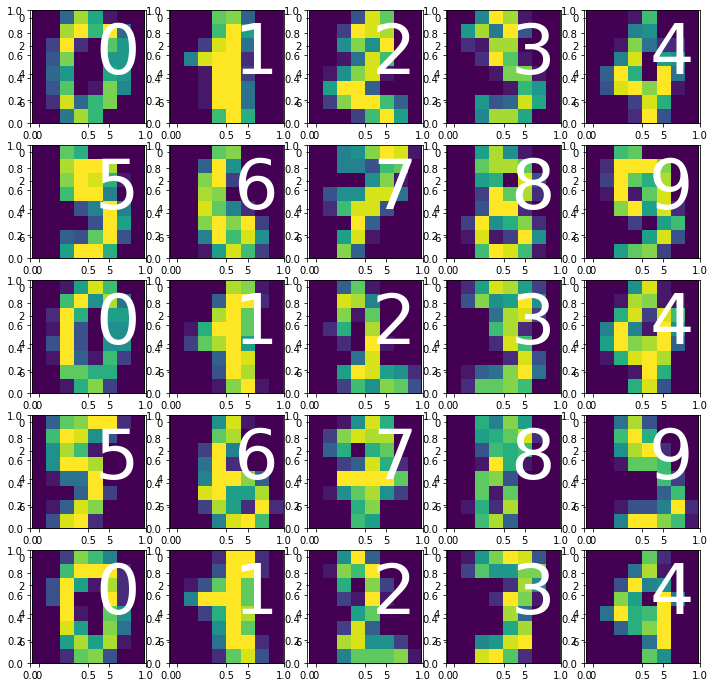

In [9]:
nx, ny = 5, 5
fig, axs = plt.subplots(nx, ny, figsize=(12, 12))
n=0
for i in range(1,26):
    etiqueta=['0','1','2','3','4','5','6','7','8','9']
    fig.add_subplot(nx,ny,i)
    plt.imshow(digits_dict["images"][i-1])
    plt.text(4,4,etiqueta[n],fontsize=70,color='white')
    n+=1
    if n==(len(etiqueta)):
        n=0
plt.show()

### Ejercicio 3

**Machine Learning**: En esta parte usted debe entrenar los distintos modelos escogidos desde la librería de `skelearn`. Para cada modelo, debe realizar los siguientes pasos:

* **train-test** 
 * Crear conjunto de entrenamiento y testeo (usted determine las proporciones adecuadas).
 * Imprimir por pantalla el largo del conjunto de entrenamiento y de testeo.
 
 
* **modelo**:
 * Instanciar el modelo objetivo desde la librería sklearn.
 * *Hiper-parámetros*: Utiliza `sklearn.model_selection.GridSearchCV` para obtener la mejor estimación de los parámetros del modelo objetivo.




* **Métricas**:
 * Graficar matriz de confusión.
 * Analizar métricas de error.



__Preguntas a responder:__

* ¿Cuál modelo es mejor basado en sus métricas?
* ¿Cuál modelo demora menos tiempo en ajustarse?
* ¿Qué modelo escoges?


In [10]:
X = digits.drop(columns="target").values
y = digits["target"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print('Largo del conjunto de entrenamiento:',len(X_train),'\nLargo del conjunto de testeo:', len(X_test))

Largo del conjunto de entrenamiento: 1347 
Largo del conjunto de testeo: 450


In [11]:
param_grid = {'n_neighbors':[1, 5, 10], 'weights':['uniform', 'distance'], 'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']} 
knn = KNeighborsClassifier()
gs = GridSearchCV(knn, param_grid)
gs.fit(X_train, y_train)
print("Best: %f con %s" % (gs.best_score_, gs.best_params_))

Best: 0.986636 con {'algorithm': 'auto', 'n_neighbors': 1, 'weights': 'uniform'}


In [12]:
param_grid= {'solver': ['liblinear', 'newton-cg', 'lbfgs'],
             'C': [1, 0.5, 0.25]}

 
rlog = LogisticRegression(random_state=42)
gs = GridSearchCV(rlog, param_grid)
gs.fit(X_train, y_train)

print("Best: %f con %s" % (gs.best_score_, gs.best_params_))


C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best: 0.953956 con {'C': 0.25, 'solver': 'lbfgs'}


C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [13]:
param_grid = {'max_depth': [3, 5, 10],
              'n_estimators': [10, 50, 100]}

 
rfc = RandomForestClassifier(random_state=42)
gs = GridSearchCV(rfc, param_grid)
gs.fit(X_train, y_train)

print("Best: %f con %s" % (gs.best_score_, gs.best_params_))


Best: 0.968074 con {'max_depth': 10, 'n_estimators': 100}


In [14]:

param_grid = {'kernel':('linear', 'rbf'),
              'C': [1,2,3,4,5,6,7,8,9,10]}

sv = SVC()

gs = GridSearchCV(sv, param_grid)

gs.fit(X_train, y_train)

print("Best: %f con %s" % (gs.best_score_, gs.best_params_))

Best: 0.988864 con {'C': 10, 'kernel': 'rbf'}


In [15]:
#modelos con hiperparámetros ya optimizados
knn = KNeighborsClassifier(algorithm= 'auto', n_neighbors= 1, weights= 'uniform')
rlog = LogisticRegression(C=0.25, random_state=42, solver='lbfgs')
rfc = RandomForestClassifier(max_depth=10, n_estimators=100, random_state=42) 
svc = SVC(C=7 , kernel='rbf')

Ahora veamos cuanto demora cada modelo

In [16]:



ti=time()
knn.fit(X_train, y_train)
tf=time()
tp=tf-ti
print("el tiempo de ejecucion de knn es de", tp, "segundos")


ti=time()
rlog.fit(X_train, y_train)
tf=time()
tp=tf-ti
print("el tiempo de ejecucion de rlog es de", tp, "segundos")


ti=time()
rfc.fit(X_train, y_train)
tf=time()
tp=tf-ti
print("el tiempo de ejecucion de rfc es de", tp, "segundos")


ti=time()
svc.fit(X_train, y_train)
tf=time()
tp=tf-ti
print("el tiempo de ejecucion de dtc es de", tp, "segundos")

el tiempo de ejecucion de knn es de 0.0009999275207519531 segundos
el tiempo de ejecucion de rlog es de 0.09331417083740234 segundos


C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


el tiempo de ejecucion de rfc es de 0.23402905464172363 segundos
el tiempo de ejecucion de dtc es de 0.04509735107421875 segundos


In [17]:
y_true =  list(y_test)
y_pred = list(knn.predict(X_test))


print('\nMatriz de confusion knn:\n ')
print(confusion_matrix(y_true,y_pred))

df_temp = pd.DataFrame(
    {
        'y':y_true,
        'yhat':y_pred
        }
)

df_metrics = summary_metrics(df_temp)
print("\nMetricas para knn:")
print(df_metrics)


Matriz de confusion knn:
 
[[43  0  0  0  0  0  0  0  0  0]
 [ 0 37  0  0  0  0  0  0  0  0]
 [ 0  0 38  0  0  0  0  0  0  0]
 [ 0  0  0 45  0  0  0  0  1  0]
 [ 0  1  0  0 54  0  0  0  0  0]
 [ 0  0  0  0  0 59  0  0  0  0]
 [ 0  0  0  0  0  0 45  0  0  0]
 [ 0  0  0  0  0  0  0 40  0  1]
 [ 0  1  0  0  0  0  0  0 36  1]
 [ 0  0  0  1  1  1  0  0  0 45]]

Metricas para knn:
   accuracy  recall  precision  fscore
0    0.9822  0.9821     0.9823   0.982


In [18]:
y_true =  list(y_test)
y_pred = list(rlog.predict(X_test))


print('\nMatriz de confusion rlog:\n ')
print(confusion_matrix(y_true,y_pred))

df_temp = pd.DataFrame(
    {
        'y':y_true,
        'yhat':y_pred
        }
)

df_metrics = summary_metrics(df_temp)
print("\nMetricas para rlog:")
print(df_metrics)


Matriz de confusion rlog:
 
[[43  0  0  0  0  0  0  0  0  0]
 [ 0 36  1  0  0  0  0  0  0  0]
 [ 0  0 38  0  0  0  0  0  0  0]
 [ 0  0  0 44  0  1  0  0  1  0]
 [ 0  1  0  0 54  0  0  0  0  0]
 [ 0  0  0  0  0 57  1  0  0  1]
 [ 0  0  0  0  0  1 44  0  0  0]
 [ 0  0  0  0  0  0  0 40  0  1]
 [ 0  0  0  0  0  1  0  0 37  0]
 [ 0  0  0  1  0  0  0  0  1 46]]

Metricas para rlog:
   accuracy  recall  precision  fscore
0    0.9756  0.9763      0.976  0.9761


In [19]:
y_true =  list(y_test)
y_pred = list(rfc.predict(X_test))


print('\nMatriz de confusion rfc:\n ')
print(confusion_matrix(y_true,y_pred))

df_temp = pd.DataFrame(
    {
        'y':y_true,
        'yhat':y_pred
        }
)

df_metrics = summary_metrics(df_temp)
print("\nMetricas para rfc:")
print(df_metrics)


Matriz de confusion rfc:
 
[[42  0  0  0  1  0  0  0  0  0]
 [ 0 37  0  0  0  0  0  0  0  0]
 [ 0  0 38  0  0  0  0  0  0  0]
 [ 0  0  0 43  0  1  0  0  2  0]
 [ 0  0  0  0 55  0  0  0  0  0]
 [ 0  1  0  0  0 57  1  0  0  0]
 [ 0  0  0  0  0  1 44  0  0  0]
 [ 0  0  0  0  0  0  0 40  0  1]
 [ 0  1  0  0  0  0  0  0 37  0]
 [ 0  0  0  0  0  1  0  2  0 45]]

Metricas para rfc:
   accuracy  recall  precision  fscore
0    0.9733  0.9742     0.9738  0.9737


In [20]:
y_true =  list(y_test)
y_pred = list(svc.predict(X_test))


print('\nMatriz de confusion svc:\n ')
print(confusion_matrix(y_true,y_pred))

df_temp = pd.DataFrame(
    {
        'y':y_true,
        'yhat':y_pred
        }
)

df_metrics = summary_metrics(df_temp)
print("\nMetricas para svc:")
print(df_metrics)


Matriz de confusion svc:
 
[[43  0  0  0  0  0  0  0  0  0]
 [ 0 37  0  0  0  0  0  0  0  0]
 [ 0  0 38  0  0  0  0  0  0  0]
 [ 0  0  1 44  0  1  0  0  0  0]
 [ 0  0  0  0 55  0  0  0  0  0]
 [ 0  0  0  0  0 59  0  0  0  0]
 [ 0  0  0  0  0  0 45  0  0  0]
 [ 0  0  0  0  0  0  0 40  0  1]
 [ 0  0  0  0  0  1  0  0 37  0]
 [ 0  0  0  0  0  0  0  1  0 47]]

Metricas para svc:
   accuracy  recall  precision  fscore
0    0.9889  0.9885     0.9896   0.989


* ¿Cuál modelo es mejor basado en sus métricas?
El modelo KNeighborsClassifier(algorithm= 'auto', n_neighbors= 1, weights= 'uniform') es el que tiene métricas más cercanas a 1, por lo que es el más certero con respecto a sus métricas.

* ¿Cuál modelo demora menos tiempo en ajustarse?
El modelo KNeighborsClassifier(algorithm= 'auto', n_neighbors= 1, weights= 'uniform') es el que menos tiempo demora en ajustarse (0.000946)

* ¿Qué modelo escoges?
El modelo KNeighborsClassifier(algorithm= 'auto', n_neighbors= 1, weights= 'uniform'), ya que es el con mejor métricas y el tiempo de demora en ajustarse es bastante bajo y cercano a 0.

### Ejercicio 4

__Comprensión del modelo:__ Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, debe comprender e interpretar minuciosamente los resultados y gráficos asocados al modelo en estudio, para ello debe resolver los siguientes puntos:



 * **Cross validation**: usando **cv** (con n_fold = 10), sacar una especie de "intervalo de confianza" sobre alguna de las métricas estudiadas en clases: 
  * $\mu \pm \sigma$ = promedio $\pm$ desviación estandar
 * **Curva de Validación**: Replica el ejemplo del siguiente [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.
 * **Curva AUC–ROC**: Replica el ejemplo del siguiente  [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.
 
 
 

In [21]:


scores = cross_val_score(svc, X, y, cv=10)

print("Promedio +- Desv. Est = %0.2f +- %0.2f" % (scores.mean(), scores.std()))

Promedio +- Desv. Est = 0.98 +- 0.02


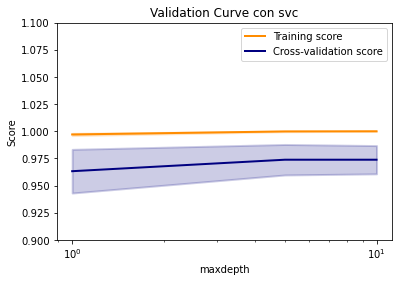

In [22]:

param_range =  [1 ,5 ,10]
train_scores, test_scores = validation_curve(
    SVC(),
    X,
    y,
    param_name='C',
    param_range=param_range,
    scoring="accuracy",
    n_jobs=1,
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve con svc")
plt.xlabel(r"maxdepth")
plt.ylabel("Score")
plt.ylim(0.9, 1.1)
lw = 2
plt.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")

plt.show()

In [23]:


#X = digits.drop(columns="target").values
#y = digits["target"].values

# Binarize the output
y = label_binarize(y, classes=digits['target'].unique())
n_classes = y.shape[1]



# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(SVC(kernel='rbf', C=7, random_state=42, probability=True))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])





<ipython-input-24-2a6e121ae44f>:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


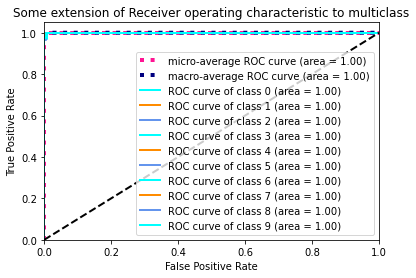

In [24]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()




### Ejercicio 5
__Reducción de la dimensión:__ Tomando en cuenta el mejor modelo encontrado en el `Ejercicio 3`, debe realizar una redcción de dimensionalidad del conjunto de datos. Para ello debe abordar el problema ocupando los dos criterios visto en clases:  

* **Selección de atributos**
* **Extracción de atributos**

__Preguntas a responder:__

Una vez realizado la reducción de dimensionalidad, debe sacar algunas estadísticas y gráficas comparativas entre el conjunto de datos original y el nuevo conjunto de datos (tamaño del dataset, tiempo de ejecución del modelo, etc.)


**Selección de atributos: SelectKbest**

In [25]:


X = digits.drop(columns="target")
y = digits["target"]

# Aplicando el algoritmo univariante de prueba F.
k = 25  # número de atributos a seleccionar
columnas = list(X.columns.values)
seleccionadas = SelectKBest(f_classif, k=k).fit(X, y)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [ 0 32 39] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\HP\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [26]:
catrib = seleccionadas.get_support()
atributos = [columnas[i] for i in list(catrib.nonzero()[0])]
atributos

['c02',
 'c10',
 'c13',
 'c18',
 'c19',
 'c20',
 'c21',
 'c26',
 'c27',
 'c28',
 'c30',
 'c33',
 'c34',
 'c35',
 'c36',
 'c38',
 'c42',
 'c43',
 'c44',
 'c46',
 'c53',
 'c54',
 'c58',
 'c60',
 'c61']

In [27]:
len(atributos)

25

In [28]:

# Entrenamiento con todas las variables 
X = digits.drop(columns="target").values
Y = digits["target"].values

# split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 2) 

# Creando el modelo
svc = SVC(C=7 , kernel='rbf')
ti=time()
svc.fit(X_train, Y_train) # ajustando el modelo
tf=time()

tp=tf-ti
print("el tiempo de ejecucion es de", tp, "segundos")
predicciones = svc.predict(X_test)

df_pred = pd.DataFrame({
    'y':Y_test,
    'yhat':predicciones
})

df_s1 = summary_metrics(df_pred).assign(name = 'Todas las variables')

el tiempo de ejecucion es de 0.035002946853637695 segundos


In [29]:

# Entrenamiento con todas las variables 
X = digits[atributos].values
Y = digits["target"].values

# split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 2) 

svc = SVC(C=7 , kernel='rbf')
ti=time()
svc.fit(X_train, Y_train) # ajustando el modelo
tf=time()

tp=tf-ti
print("el tiempo de ejecucion es de", tp, "segundos")

predicciones = svc.predict(X_test)

df_pred = pd.DataFrame({
    'y':Y_test,
    'yhat':predicciones
})

df_s2 = summary_metrics(df_pred).assign(name = '25 variables')

el tiempo de ejecucion es de 0.03208518028259277 segundos


In [30]:
# juntar resultados en formato dataframe
pd.concat([df_s1,df_s2])

,accuracy,recall,precision,fscore,name
0,0.9778,0.9763,0.9794,0.9774,Todas las variables
0,0.9639,0.9633,0.9660,0.9640,25 variables


Vemos que las métricas y el tiempo de ejecución es bastante similar con las 25 variables seleccionadas, aunque sigue ajustandose de mejor forma con todas las variables.

**Extracción de atributos: PCA**

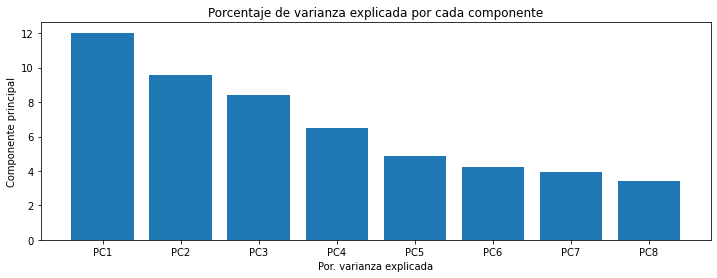

In [31]:


X = digits.drop(columns="target").values
y = digits["target"].values

# Entrenamiento modelo PCA con escalado de los datos
# ==============================================================================


# Se extrae el modelo entrenado del pipeline
pca = make_pipeline(StandardScaler(), PCA(n_components=8))
X_transform = pca.fit_transform(X)

modelo_pca = pca.named_steps['pca']
    
df_pca = pd.DataFrame(data=X_transform , columns = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8'])
df_pca['target'] = y


percent_variance = np.round(modelo_pca.explained_variance_ratio_* 100, decimals =2)
columns = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8']

plt.figure(figsize=(12,4))
plt.bar(x= range(1,9), height=percent_variance, tick_label=columns)
plt.xticks(np.arange(modelo_pca.n_components_) + 1)

plt.ylabel('Componente principal')
plt.xlabel('Por. varianza explicada')
plt.title('Porcentaje de varianza explicada por cada componente')
plt.show()

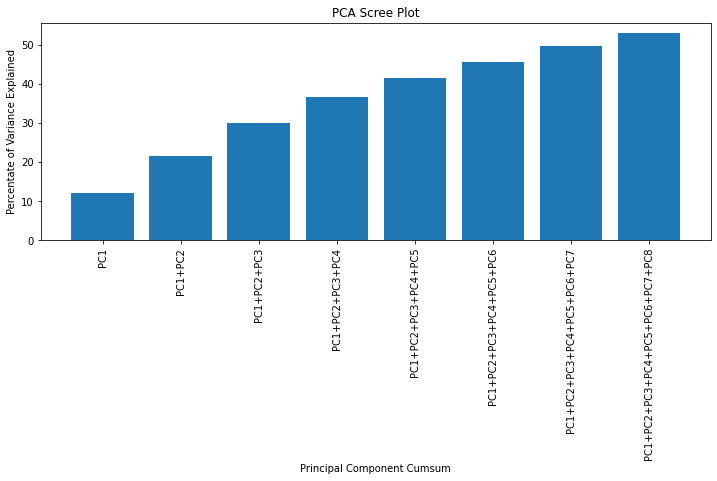

In [32]:
percent_variance_cum = np.cumsum(percent_variance)
columns = ['PC1', 'PC1+PC2', 'PC1+PC2+PC3', 'PC1+PC2+PC3+PC4','PC1+PC2+PC3+PC4+PC5','PC1+PC2+PC3+PC4+PC5+PC6','PC1+PC2+PC3+PC4+PC5+PC6+PC7','PC1+PC2+PC3+PC4+PC5+PC6+PC7+PC8']

plt.figure(figsize=(12,4))
plt.bar(x= range(1,9), height=percent_variance_cum, tick_label=columns)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component Cumsum')
plt.xticks(rotation=90)
plt.title('PCA Scree Plot')
plt.show()

In [33]:
# Entrenamiento con todas las variables 
X = df_pca.drop(columns='target').values
Y = df_pca["target"].values

# split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 2) 

svc = SVC(C=7 , kernel='rbf')
ti=time()
svc.fit(X_train, Y_train) # ajustando el modelo
tf=time()

tp=tf-ti
print("el tiempo de ejecucion es de", tp, "segundos")

predicciones = svc.predict(X_test)

df_pred = pd.DataFrame({
    'y':Y_test,
    'yhat':predicciones
})

df_s3 = summary_metrics(df_pred).assign(name = 'PCA')

el tiempo de ejecucion es de 0.027940750122070312 segundos


In [34]:
pd.concat([df_s1,df_s3])

,accuracy,recall,precision,fscore,name
0,0.9778,0.9763,0.9794,0.9774,Todas las variables
0,0.9417,0.9386,0.9421,0.9400,PCA


De aquí observamos que el tiempo es bastante cercano con extracción de variables, pero sus métricas se alejan un poco del 1.

### Ejercicio 6


__Visualizando Resultados:__ A continuación se provee código para comparar las etiquetas predichas vs las etiquetas reales del conjunto de _test_. 


In [35]:
def mostar_resultados(digits,model,nx=5, ny=5,label = "correctos"):
    
    X = digits.drop(columns="target").values
    Y = digits["target"].values
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 42) 
    model.fit(X_train, Y_train) # ajustando el modelo
    Y_pred = list(model.predict(X_test))

    
    # Mostrar los datos correctos
    if label=="correctos":
        mask = Y_pred == Y_test
        color = "green"
        
    # Mostrar los datos correctos
    elif label=="incorrectos":
        mask = Y_pred != Y_test
        color = "red"
    
    else:
        raise ValueError("Valor incorrecto")
        
    X_aux = X_test[mask]
    y_aux_true = np.array(Y_test)[mask]
    y_aux_pred = np.array(Y_pred)[mask]

    # We'll plot the first 100 examples, randomly choosen
    fig, ax = plt.subplots(nx, ny, figsize=(12,12))
    for i in range(nx):
        for j in range(ny):
            index = j + ny * i
            data  = X_aux[index, :].reshape(8,8)
            label_pred = str(int(y_aux_pred[index]))
            label_true = str(int(y_aux_true[index]))
            ax[i][j].imshow(data, interpolation='nearest', cmap='gray_r')
            ax[i][j].text(0, 0, label_pred, horizontalalignment='center', verticalalignment='center', fontsize=10, color=color)
            ax[i][j].text(7, 0, label_true, horizontalalignment='center', verticalalignment='center', fontsize=10, color='blue')
            ax[i][j].get_xaxis().set_visible(False)
            ax[i][j].get_yaxis().set_visible(False)
    plt.show()

**Pregunta**

* Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, grafique los resultados cuando:
 * el valor predicho y original son iguales
 * el valor predicho y original son distintos 


* Cuando el valor predicho y original son distintos ,  ¿Por qué ocurren estas fallas?

In [36]:
scv=SVC(C=7, kernel='rbf')

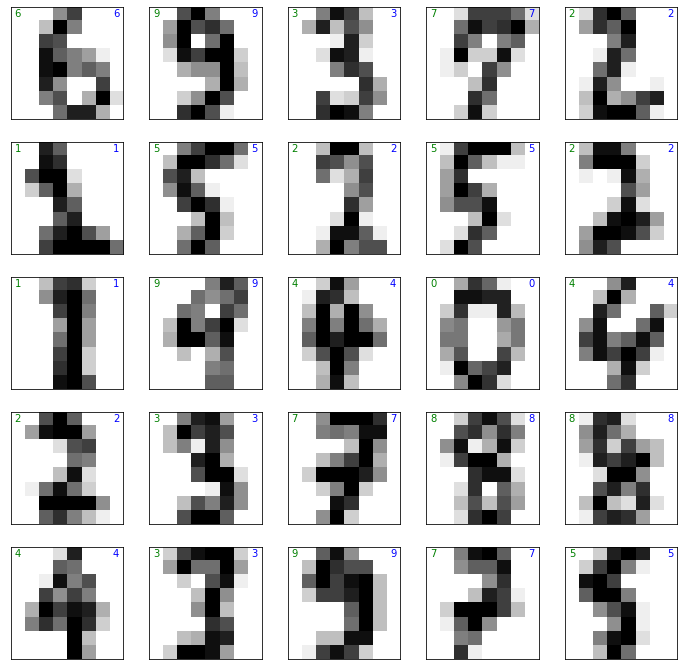

In [37]:
mostar_resultados(digits,svc,nx=5, ny=5,label = "correctos")

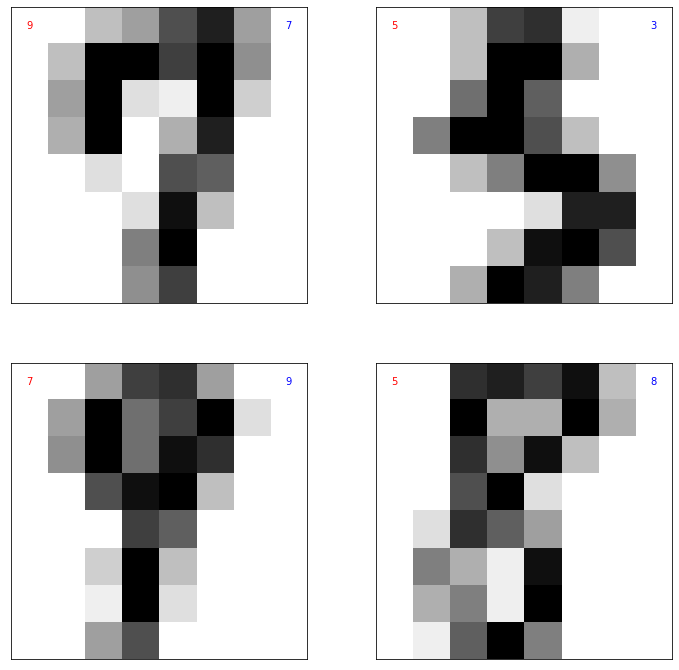

In [38]:
mostar_resultados(digits,svc,nx=2, ny=2,label = "incorrectos")

### Ejercicio 7
**Conclusiones**: Entrega tu veredicto, responde las preguntas iniciales, visualizaciones, trabajos futuros, dificultades, etc.


Podemos observar que el modelo escogido es bastante certero, podemos fijarnos en que sus métricas son bastante cercanas a uno y además demora poco tiempo en ajustarse a los datos. Además por las imágenes del Ejercicio 7 vemos que los incorrectos al ojo humano también lo son, aunque esto depende mucho de la caligrafía de cada persona.

## II.- California Housing Prices


<img src="https://www.wartsila.com/images/default-source/default-album/california_housing.tmb-1920x690.jpg?sfvrsn=126bc44_1" width="480" height="240" align="center"/>

Los datos se refieren a las casas encontradas en un distrito determinado de California y algunas estadísticas resumidas sobre ellas basadas en los datos del censo de 1990. Tenga en cuenta que los datos no se limpian, por lo que se requieren algunos pasos de procesamiento previo.

Las columnas son las siguientes, sus nombres se explican por sí mismos:

* longitude
* latitude
* housingmedianage
* total_rooms
* total_bedrooms
* population
* households
* median_income
* medianhousevalue
* ocean_proximity


El objetivo es poder predecir el valor promedio de cada propiedad. 
Para poder completar correctamente este laboratorio, es necesario seguir la siguiente rúbrica de trabajo:

1. Definición del problema
2. Estadística descriptiva
3. Visualización descriptiva
4. Preprocesamiento
5. Selección de modelo 
    1. Por lo menos debe comparar cuatro modelos
    2. Al menos tres de estos modelos tienen que tener hiperparámetros.
    3. Realizar optimización de hiperparámetros.
6. Métricas y análisis de resultados
7. Visualizaciones del modelo
8. Conclusiones

> **Observación**: Puede tomar como referencia lo realizado en la sección **I.- Clasificación de dígitos**. El alumno tiene la libertad de desarrollar un análisis más completo del problema (si así lo desea). Puede tomar como referencia el siguiente [link](https://www.kaggle.com/camnugent/california-housing-prices).

In [39]:
# read data
housing = pd.read_csv('data/housing.csv',sep=',')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [40]:
housing.describe().drop(columns=['longitude','latitude'])

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [41]:
housing.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 2.7 MB


In [42]:
housing['ocean_proximity'].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [43]:
#Cambiamos a valor numerico el ocean proximity
housing['ocean_proximity'] = housing['ocean_proximity'].replace(['NEAR BAY','<1H OCEAN','INLAND','NEAR OCEAN','ISLAND'],[3,2,4,1,0])

housing['ocean_proximity'].unique()

array([3, 2, 4, 1, 0], dtype=int64)

In [44]:
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [45]:
#cambiamos los valores nulos por el promedio
housing['total_bedrooms'].fillna(housing['total_bedrooms'].mean(), inplace=True)
housing.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [46]:
#Ahora para trabajar con clases 

housing['median_house_value'] = np.where(housing['median_house_value'].between(0,50000), 25000 , housing['median_house_value'])

housing['median_house_value'] = np.where(housing['median_house_value'].between(50001,100000), 75000 , housing['median_house_value'])

housing['median_house_value'] = np.where(housing['median_house_value'].between(100001,150000), 125000 , housing['median_house_value'])

housing['median_house_value'] = np.where(housing['median_house_value'].between(150001,200000), 175000 , housing['median_house_value'])

housing['median_house_value'] = np.where(housing['median_house_value'].between(200001,250000), 225000 , housing['median_house_value'])

housing['median_house_value'] = np.where(housing['median_house_value'].between(250001,300000), 275000 , housing['median_house_value'])

housing['median_house_value'] = np.where(housing['median_house_value'].between(300001,350000), 325000 , housing['median_house_value'])

housing['median_house_value'] = np.where(housing['median_house_value'].between(350001,400000), 375000 , housing['median_house_value'])

housing['median_house_value'] = np.where(housing['median_house_value'].between(400001,450000), 425000 , housing['median_house_value'])

housing['median_house_value'] = np.where(housing['median_house_value'].between(450001,500001), 475000 , housing['median_house_value'])

housing['median_house_value'].unique()


array([475000., 375000., 325000., 275000., 225000., 175000., 125000.,
        75000., 425000.,  25000.])

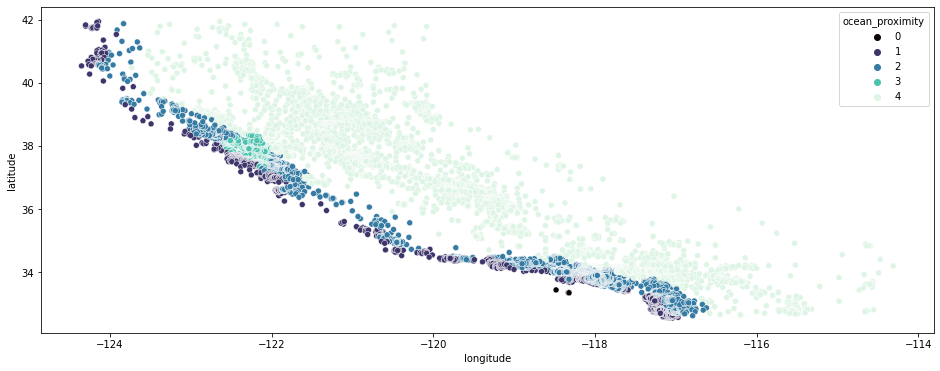

In [47]:
plt.figure(figsize=(16,6))
fig = sns.scatterplot(x='longitude', 
                      y='latitude', 
                      hue='ocean_proximity',
                      data =housing,
                      palette='mako'
                      )
plt.show()

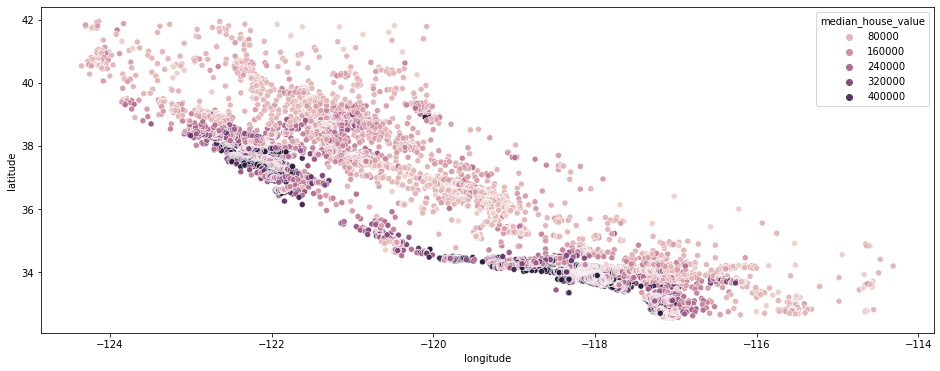

In [48]:
plt.figure(figsize=(16,6))
fig = sns.scatterplot(x='longitude', 
                      y='latitude', 
                      hue='median_house_value',
                      data =housing
                      )
plt.show()


**Machine Learning**

In [66]:
X = housing.drop(columns=['median_house_value']).values  
y = housing["median_house_value"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print('Largo del conjunto de entrenamiento:',len(X_train),'\nLargo del conjunto de testeo:', len(X_test))

Largo del conjunto de entrenamiento: 15480 
Largo del conjunto de testeo: 5160


In [50]:
param_grid = {'n_neighbors':[1, 5, 10], 'weights':['uniform', 'distance'], 'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']} 
knn = KNeighborsClassifier()
gs = GridSearchCV(knn, param_grid)
gs.fit(X_train, y_train)
print("Best: %f con %s" % (gs.best_score_, gs.best_params_))

Best: 0.241473 con {'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'distance'}


In [51]:
param_grid= {'solver': ['liblinear', 'newton-cg', 'lbfgs'],
             'C': [1, 0.5, 0.25]}

 
rlog = LogisticRegression(random_state=42)
gs = GridSearchCV(rlog, param_grid)
gs.fit(X_train, y_train)

print("Best: %f con %s" % (gs.best_score_, gs.best_params_))


C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increas

C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best: 0.429780 con {'C': 1, 'solver': 'newton-cg'}


C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


In [52]:
param_grid = {'max_depth': [3, 5, 10],
              'n_estimators': [10, 50, 100]}

 
rfc = RandomForestClassifier(random_state=42)
gs = GridSearchCV(rfc, param_grid)
gs.fit(X_train, y_train)

print("Best: %f con %s" % (gs.best_score_, gs.best_params_))



Best: 0.514729 con {'max_depth': 10, 'n_estimators': 100}


In [53]:
param_grid = {'max_depth': [3, 5, 10],
              'min_samples_split': [2, 5, 10]}


dtc = DecisionTreeClassifier(random_state=42)

gs = GridSearchCV(dtc, param_grid)

gs.fit(X_train, y_train)

print("Best: %f con %s" % (gs.best_score_, gs.best_params_))

Best: 0.471253 con {'max_depth': 10, 'min_samples_split': 10}


In [54]:
#modelos con hiperparámetros ya optimizados
knn = KNeighborsClassifier(algorithm= 'auto', n_neighbors= 10, weights= 'distance')
rlog = LogisticRegression(random_state=42, C=1, solver='newton-cg')
rfc = RandomForestClassifier(random_state=42, max_depth=10, n_estimators=100)
dtc = DecisionTreeClassifier(random_state=42, max_depth= 10, min_samples_split= 10)

¿Cuánto demoran en aplicarse los modelos?

In [55]:
ti=time()
knn.fit(X_train, y_train)
tf=time()
tp=tf-ti
print("el tiempo de ejecucion de knn es de", tp, "segundos")

ti=time()
rlog.fit(X_train, y_train)
tf=time()
tp=tf-ti
print("el tiempo de ejecucion de rlog es de", tp, "segundos")

ti=time()
rfc.fit(X_train, y_train)
tf=time()
tp=tf-ti
print("el tiempo de ejecucion de rfc es de", tp, "segundos")

ti=time()
dtc.fit(X_train, y_train)
tf=time()
tp=tf-ti
print("el tiempo de ejecucion de dtc es de", tp, "segundos")




el tiempo de ejecucion de knn es de 0.047711849212646484 segundos


C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


el tiempo de ejecucion de rlog es de 26.979024410247803 segundos
el tiempo de ejecucion de rfc es de 1.9615399837493896 segundos
el tiempo de ejecucion de dtc es de 0.07811141014099121 segundos


In [56]:
y_true =  list(y_test)
y_pred = list(knn.predict(X_test))


print('\nMatriz de confusion knn:\n ')
print(confusion_matrix(y_true,y_pred))

df_temp = pd.DataFrame(
    {
        'y':y_true,
        'yhat':y_pred
        }
)

df_metrics1 = summary_metrics(df_temp).assign(name = 'knn')
print("\nMetricas para knn:")
print(df_metrics1)


Matriz de confusion knn:
 
[[  0  20  15  12   3   4   1   0   0   1]
 [  1 274 217 206  98  32  15   6   1  18]
 [  0 203 269 255 141  50  18  11   3  22]
 [  1 231 270 327 135  63  19  19   3  29]
 [  0 125 147 182 131  70  30  22   2  27]
 [  0  69  89  92  87  58  36  14   7  29]
 [  0  48  50  41  57  42  29   9   1  42]
 [  0  23  14  29  31  25  29  16   5  28]
 [  0   9   7  18  19  19  12   9   1  29]
 [  0  21  26  40  19  26  15  18   9 134]]

Metricas para knn:
   accuracy  recall  precision  fscore name
0    0.2401  0.1803      0.179  0.1771  knn


In [57]:
y_true =  list(y_test)
y_pred = list(rlog.predict(X_test))


print('\nMatriz de confusion rlog:\n ')
print(confusion_matrix(y_true,y_pred))

df_temp = pd.DataFrame(
    {
        'y':y_true,
        'yhat':y_pred
        }
)

df_metrics3 = summary_metrics(df_temp).assign(name = 'rlog')
print("\nMetricas para dtc:")
print(df_metrics3)


Matriz de confusion rlog:
 
[[  0  50   3   3   0   0   0   0   0   0]
 [  0 605 197  57   2   5   0   0   0   2]
 [  0 237 397 302  25  10   0   0   0   1]
 [  1  72 237 621 129  25   2   0   0  10]
 [  0  20  62 308 250  74   2   1   0  19]
 [  0   7  19 135 122 151   2   0   0  45]
 [  0   3  14  56  91 102   0   2   0  51]
 [  0   3   5  25  39  54   0   1   0  73]
 [  0   1   2   9  19  32   1   3   0  56]
 [  0   2   6  19  27  25   2   2   0 225]]

Metricas para dtc:
   accuracy  recall  precision  fscore  name
0     0.436  0.3061      0.268  0.2776  rlog


C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [58]:
y_true =  list(y_test)
y_pred = list(rfc.predict(X_test))


print('\nMatriz de confusion rfc:\n ')
print(confusion_matrix(y_true,y_pred))

df_temp = pd.DataFrame(
    {
        'y':y_true,
        'yhat':y_pred
        }
)

df_metrics2 = summary_metrics(df_temp).assign(name = 'rfc')
print("\nMetricas para rfc:")
print(df_metrics2)


Matriz de confusion rfc:
 
[[  0  52   2   1   1   0   0   0   0   0]
 [  1 666 180  19   0   0   1   0   0   1]
 [  0 159 574 221  17   0   0   0   0   1]
 [  0  25 229 731 104   7   0   1   0   0]
 [  0   8  39 332 277  69   5   2   0   4]
 [  0   2  20 122 146 163  16   4   0   8]
 [  0   0   9  47  77  82  70  19   0  15]
 [  0   0   4  26  43  41  24  13   0  49]
 [  0   1   2  12  22  19  12  12   1  42]
 [  0   1   3  28  32  22  14   7   0 201]]

Metricas para rfc:
   accuracy  recall  precision  fscore name
0    0.5225  0.3685     0.4877  0.3676  rfc


In [59]:
y_true =  list(y_test)
y_pred = list(dtc.predict(X_test))


print('\nMatriz de confusion dtc:\n ')
print(confusion_matrix(y_true,y_pred))

df_temp = pd.DataFrame(
    {
        'y':y_true,
        'yhat':y_pred
        }
)

df_metrics4 = summary_metrics(df_temp).assign(name = 'dtc')
print("\nMetricas para dtc:")
print(df_metrics4)


Matriz de confusion dtc:
 
[[  0  49   4   2   0   1   0   0   0   0]
 [  3 646 181  36   1   0   1   0   0   0]
 [  0 189 503 246  26   5   1   1   0   1]
 [  0  44 204 698 111  22  12   0   5   1]
 [  0  12  36 319 234 104  22   2   2   5]
 [  0   5  24 104 115 151  58   8   2  14]
 [  0   0   8  40  41  83  99  21   9  18]
 [  0   1   3  24  19  49  47  20  10  27]
 [  0   0   1  11  10  24  23  13  15  26]
 [  0   1   4  20  14  25  37  11  19 177]]

Metricas para dtc:
   accuracy  recall  precision  fscore name
0    0.4928  0.3637     0.3895  0.3686  dtc


In [60]:
pd.concat([df_metrics1,df_metrics2,df_metrics3,df_metrics4])

,accuracy,recall,precision,fscore,name
0,0.2401,0.1803,0.1790,0.1771,knn
0,0.5225,0.3685,0.4877,0.3676,rfc
0,0.4360,0.3061,0.2680,0.2776,rlog
0,0.4928,0.3637,0.3895,0.3686,dtc


* ¿Cuál modelo es mejor basado en sus métricas?
El modelo  **RandomForestClassifier(random_state=42, max_depth=10, n_estimators=100)** es el que tiene métricas más cercanas a 1, por lo que es el más certero
* ¿Cuál modelo demora menos tiempo en ajustarse?
El modelo **KNeighborsClassifier(algorithm= 'auto', n_neighbors= 10, weights= 'distance')** es el que menos tiempo demora en ajustarse (0.0477 sec)
* ¿Qué modelo escoges?
El modelo **RandomForestClassifier(random_state=42, max_depth=10, n_estimators=100)**, ya que es el con mejor métricas y el tiempo de demora en ajustarse es bastante bajo y cercano a 0.


**CROSS VALIDATION**

In [67]:
scores = cross_val_score(rfc, X, y, cv=10)

print("Promedio +- Desv. Est = %0.2f +- %0.2f" % (scores.mean(), scores.std()))

Promedio +- Desv. Est = 0.34 +- 0.08


**VALIDATION CURVE**

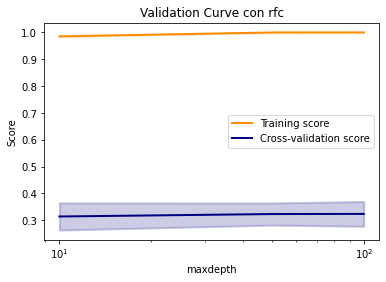

In [69]:
param_range= [10, 50, 100]
train_scores, test_scores = validation_curve(
    RandomForestClassifier(),
    X,
    y,
    param_name='n_estimators',
    param_range=param_range,
    scoring="accuracy",
    n_jobs=1,
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve con rfc")
plt.xlabel(r"maxdepth")
plt.ylabel("Score")
#plt.ylim(0.9, 1.1)
lw = 2
plt.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")

plt.show()

**Reducción de dimensionalidad: PCA**

In [61]:
X = housing.drop(columns=['median_house_value'])
y = housing['median_house_value']
    
pca = make_pipeline(StandardScaler(), PCA(n_components=8))
X_transform = pca.fit_transform(X)

modelo_pca = pca.named_steps['pca']
    
df_pca = pd.DataFrame(data=X_transform , columns = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8'])
df_pca['median_house_value'] = y

In [62]:
X = df_pca.drop(columns='median_house_value')
y = df_pca['median_house_value']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [63]:
rfc=RandomForestClassifier(random_state=42, max_depth=10, n_estimators=100)

In [64]:
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [65]:
y_true =  list(y_test)
y_pred = list(rfc.predict(X_test))


print('\nMatriz de confusion rfc:\n ')
print(confusion_matrix(y_true,y_pred))

df_temp = pd.DataFrame(
    {
        'y':y_true,
        'yhat':y_pred
        }
)

df_metrics2 = summary_metrics(df_temp).assign(name = 'rfc')
print("\nMetricas para rfc:")
print(df_metrics2)


Matriz de confusion rfc:
 
[[  1  50   2   3   0   0   0   0   0   0]
 [  1 659 176  30   0   0   0   0   0   2]
 [  0 165 530 255  18   3   0   0   0   1]
 [  0  33 214 716 113  14   0   0   0   7]
 [  0   8  43 308 267  98   2   0   0  10]
 [  0   4  17 114 132 182  17   1   0  14]
 [  0   0   9  53  89  98  35  10   0  25]
 [  0   0   3  19  42  59  12  18   0  47]
 [  0   1   1  12  20  24  11   9   1  44]
 [  0   5   2  16  31  26  14   4   0 210]]

Metricas para rfc:
   accuracy  recall  precision  fscore name
0    0.5076  0.3606     0.5346  0.3557  rfc


Vemos que las métricas se mantienen bastante parecidas luego del PCA e incluso para algunas mejoran.

Podemos ver que ninguno de los modelos se ajusta como deseariamos, sin embargo el mejor es el correspondiente a RandomForestClassifier(random_state=42, max_depth=10, n_estimators=100) dado que su accuracy es más cercano a 1 que cualquier otro.